# Convolutional Neural Network (CNN) on MNIST dataset
## Jakub Kostrzębski

<a id="1"></a>
## Importing Basic Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
os. getcwd()
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
## Loading the Data Set
* In this part we load and visualize the data.

In [2]:
# read the dataset 
db = pd.read_csv("numbers.csv")
print(db.shape)
db.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# put labels into y_train variable
Y_db = db["label"]
# Drop 'label' column
X_db = db.drop(labels = ["label"],axis = 1) 

Text(0.5, 1.0, 'Number of digit classes')

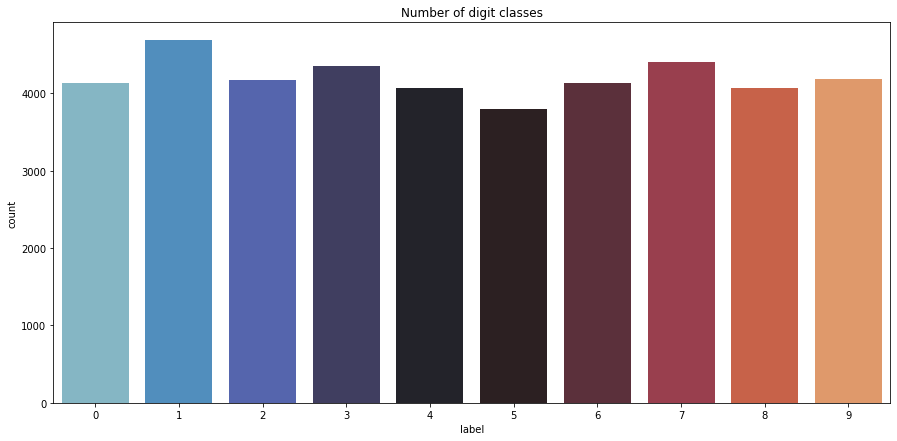

In [4]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_db, palette="icefire")
plt.title("Number of digit classes")
#Y_train.value_counts()

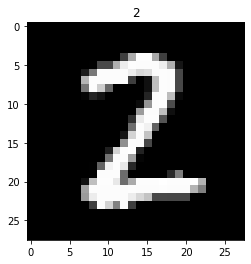

In [7]:
# plot some samples
rand = random.randint(0,100)
img = X_db.iloc[rand]
img = img.values.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(db.iloc[rand,0])
plt.show()

<a id="2"></a>
## Normalization, Reshape and Label Encoding 
* Normalization
    * After normalization CNN works faster.
* Reshape
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra channel dimension. For colours it this would take value of 3 for R,G,B. Our images are gray so it use only one channel. 
* Label Encoding  
    * Encode labels to one hot vectors 
        * 8 => [0,0,0,0,0,0,0,0,1,0] etc.

In [8]:
# Normalize the data
X_db = X_db / 255.0
print("x_db shape: ",X_db.shape)

x_db shape:  (42000, 784)


In [9]:
# Reshape
X_db = X_db.values.reshape(-1,28,28,1)
print("x_train shape: ",X_db.shape)

x_train shape:  (42000, 28, 28, 1)


In [10]:
# Label Encoding
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_db = to_categorical(Y_db, num_classes = 10)
print(Y_db)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


<a id="3"></a>
## Train Data Split
* We split the data into train and validation sets.
* validation size is 20%.
* train size is 80%.

In [11]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_db, Y_db, test_size = 0.2, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (33600, 28, 28, 1)
x_test shape (8400, 28, 28, 1)
y_train shape (33600, 10)
y_test shape (8400, 10)


<a id="15"></a>
### Data Augmentation
* To avoid overfitting problem and to better train the network, we expand the dataset artificially by increaseing/decreasing size of the images by 10%, randomly shifting their place horizontally and vertically by 10%, and randomly rotating them by up to 5 degrees.
* For this we use ImageDataGenerator() from keras package.

In [12]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

<a id="11"></a>
## Create Model with Keras
* Convolution Operation: reduces size of the image, detects edges and convex shapes.
* ReLU: increases nonlinearity
* Same padding: similar to convolution operation but does not reduce size of the image. In the early stages of the model we want to preserve more data.
* Max Pooling: reduces the amount of parameters and computation in the network. Allows to somewhat control overfitting
* Dropout: randomly selected neurons are ignored during training.
* conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)

In [13]:
# 
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

model1 = Sequential()
#
model1.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
#
model1.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))
# fully connected
model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(10, activation = "softmax"))

# copy models for hyperparameter testing
model2 = clone_model(model1)
model3 = clone_model(model1)

<a id="13"></a>
### Compile Model
* Loss function of choice: categorical crossentropy

In [14]:
# Define the optimizer
optimizer1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999) #accuracy: 0.9488 - val_accuracy: 0.9840
optimizer2 = Adam(lr=0.005, beta_1=0.9, beta_2=0.999) #accuracy: 0.9612 - val_accuracy: 0.9871
optimizer3 = Adam(lr=0.01, beta_1=0.9, beta_2=0.999) #accuracy: 0.9439 - val_accuracy: 0.9821

In [15]:
# Compile the model
model1.compile(optimizer = optimizer1 , loss = "categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer = optimizer2 , loss = "categorical_crossentropy", metrics=["accuracy"])
model3.compile(optimizer = optimizer3 , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
# Setting number of epochs and batch size.
# Higher number of epochs require more computing power but should produce better results.
epochs = 10
batch_size = 250

<a id="16"></a>
### Fit the model

In [17]:
# Fit the model
history1 = model1.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch=X_train.shape[0] // batch_size)
history2 = model2.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch=X_train.shape[0] // batch_size)
history3 = model3.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
134/134 [==============================] - 7s 49ms/step - loss: 1.1570 - accuracy: 0.6149 - val_loss: 0.2621 - val_accuracy: 0.9302
Epoch 2/10
134/134 [==============================] - 6s 48ms/step - loss: 0.4622 - accuracy: 0.8541 - val_loss: 0.1443 - val_accuracy: 0.9581
Epoch 3/10
134/134 [==============================] - 6s 48ms/step - loss: 0.3314 - accuracy: 0.8950 - val_loss: 0.1108 - val_accuracy: 0.9687
Epoch 4/10
134/134 [==============================] - 7s 48ms/step - loss: 0.2811 - accuracy: 0.9121 - val_loss: 0.0950 - val_accuracy: 0.9707
Epoch 5/10
134/134 [==============================] - 6s 48ms/step - loss: 0.2547 - accuracy: 0.9208 - val_loss: 0.0825 - val_accuracy: 0.9756
Epoch 6/10
134/134 [==============================] - 7s 49ms/step - loss: 0.2306 - accuracy: 0.9285 - val_loss: 0.0776 - val_accuracy: 0.9767
Epoch 7/10
134/134 [==============================] - 7s 49ms/step - loss: 0.2054 - accuracy: 0.9372 - val_loss: 0.0705 - val_accuracy: 0.9774

<a id="16"></a>
### Loss Visualization for Training and Test Sets
* Model 1 (lowest learning rate) has the smoothest curve for val_loss reduction.
* Model 2 achieved the lowest loss and highest accuracy for validation data.
* Model 3 has the most rocky curve, the optimizer makes big 'jumps' in search of the minima.

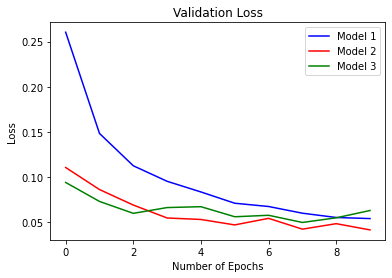

In [76]:
# Plot the loss curves for validation
plt.plot(history1.history['val_loss'], color='b', label="Model 1")
plt.plot(history2.history['val_loss'], color='r', label="Model 2")
plt.plot(history3.history['val_loss'], color='g', label="Model 3")
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

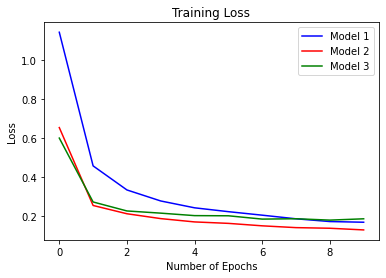

In [80]:
# Plot the loss curves for training
plt.plot(history1.history['loss'], color='b', label="Model 1")
plt.plot(history2.history['loss'], color='r', label="Model 2")
plt.plot(history3.history['loss'], color='g', label="Model 3")
plt.title("Training Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

<a id="16"></a>
### Confusion Matrix and Test Accuracy
* Model 1 accuracy:  0.9825
* Model 2 accuracy:  0.9857
* Model 3 accuracy:  0.9808

263/263 [==============================] - 1s 2ms/step


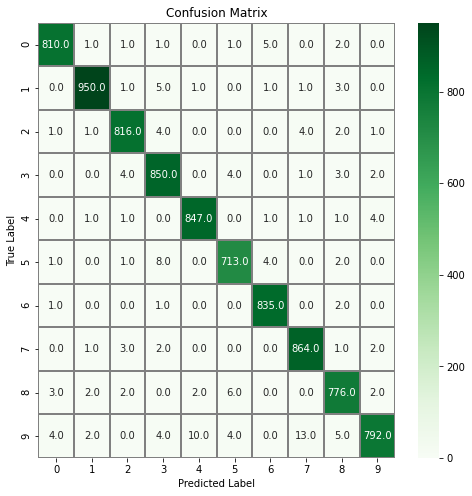

Accuracy:  0.9825


In [38]:
# confusion matrix model 1
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Predict the values from the validation dataset
Y_pred = model1.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print("Accuracy: ", round(accuracy_score(Y_true, Y_pred_classes),4))

263/263 [==============================] - 1s 2ms/step


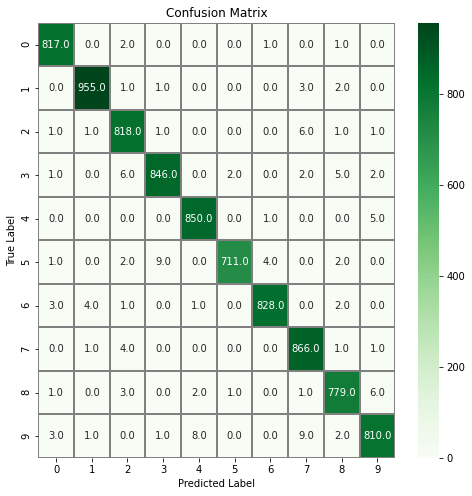

Accuracy:  0.9857


In [39]:
# confusion matrix model 2

# Predict the values from the validation dataset
Y_pred = model2.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print("Accuracy: ", round(accuracy_score(Y_true, Y_pred_classes),4))

263/263 [==============================] - 1s 2ms/step


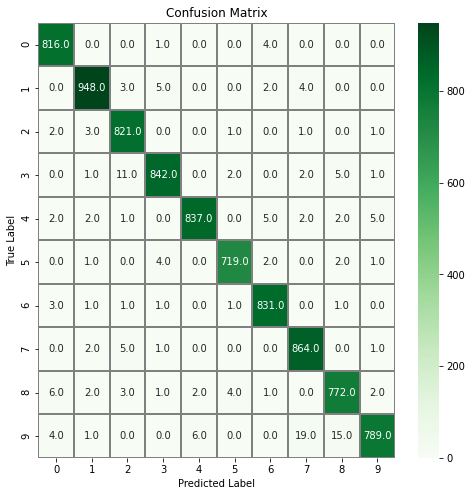

Accuracy:  0.9808


In [40]:
# confusion matrix model 3

# Predict the values from the validation dataset
Y_pred = model3.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print("Accuracy: ", round(accuracy_score(Y_true, Y_pred_classes),4))

<a id="18"></a>
## Sources
* https://www.geeksforgeeks.org/intuition-of-adam-optimizer/#:~:text=Adam%20optimizer%20involves%20a%20combination,minima%20in%20a%20faster%20pace. - optimizer choice
* https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/ - loss function choice
* https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks - epochs and iterations